# Task 4 : Image Reconstruction using Matrix Factorisation [4 Marks]

Use the [instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/movie-recommendation-knn-mf.ipynb) on matrix factorisation, and solve the following questions. Here, ground truth pixel values are missing for particular regions within the image- you don't have access to them.

1. Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank $r$. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics.  **[1 Marks]**

2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.**[3 Marks]**


## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from metrics import calculate_rmse, calculate_psnr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utility Functions

In [121]:
def display_image(img, gray=True):
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    
# Mask the image with NaN values 
def mask_image(img, prop, colour=False):
	if colour:
		img_copy = img.clone().permute(1, 2, 0)
	else:
		img_copy = img.clone()
	mask = torch.rand((img_copy.shape[0], img_copy.shape[1])) < prop
    # img_copy[200:300, 200:300] = float('nan')
	if colour:
		img_copy[:, :, 0][mask] = float('nan')
		img_copy[:, :, 1][mask] = float('nan')
		img_copy[:, :, 2][mask] = float('nan')
	else:
		img_copy[mask] = float('nan')
	if colour:
		img_copy = img_copy.permute(2, 0, 1)
	return img_copy, mask

## Loading the image

Shape of the original Image: torch.Size([3, 1599, 899])
Shape of the Cropped image torch.Size([3, 800, 500])
Shape of Greyscale image: torch.Size([800, 500])


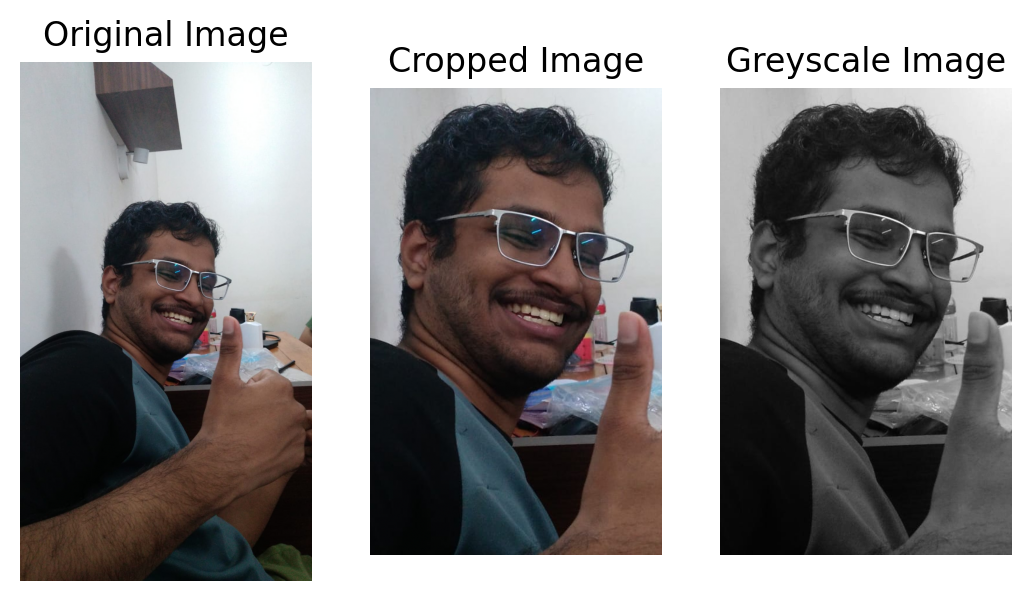

In [127]:
# Read in a image from torchvision
def load_image(path, crop_args=(400, 200, 800, 500)):
	img = torchvision.io.read_image(path)
	print("Shape of the original Image:", img.shape)

	img = (img.clone().detach().to(float))
	plt.subplot(1, 3, 1)
	display_image(img.permute(1, 2, 0) / 255, gray=False)
	plt.title("Original Image")

	img = torchvision.transforms.functional.crop(img.clone().detach().to(float), *crop_args)
	greyscale = img.mean(dim=0, keepdim=False) # convert to grayscale
	print("Shape of the Cropped image", img.shape)
	plt.subplot(1, 3, 2)
	display_image(img.permute(1, 2, 0) / 255)
	plt.title("Cropped Image")
 
	# crop = torchvision.transforms.functional.crop(img, 400, 200, 800, 500)
	print("Shape of Greyscale image:", greyscale.shape)
	plt.subplot(1, 3, 3)
	display_image(greyscale)
	plt.title("Greyscale Image")
	return img, greyscale

img, greyscale = load_image("./sample_images/bro.jpg")

## Masking the image

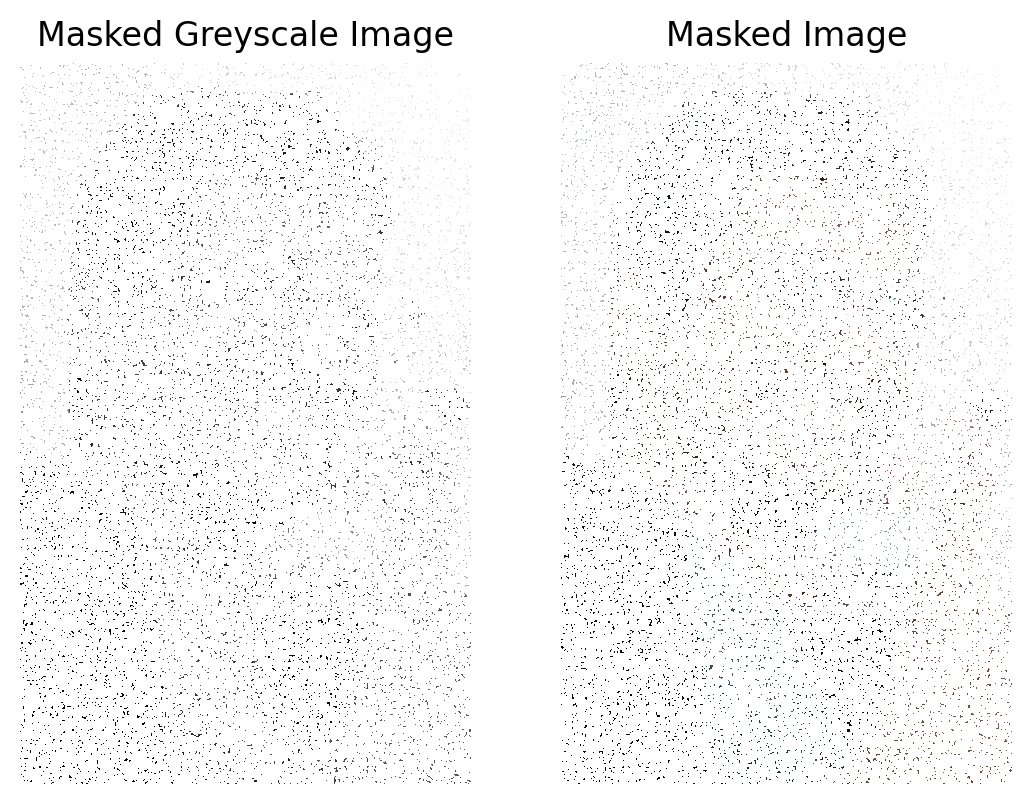

In [128]:
masked_greyscale_img, _= mask_image(greyscale, 0.5)
masked_img, _= mask_image(img, 0.5, colour=True)

plt.subplot(1, 2, 1)
plt.title("Masked Greyscale Image")
display_image(masked_greyscale_img)
plt.subplot(1, 2, 2)
plt.title("Masked Image")
display_image(masked_img.permute(1, 2, 0) / 255, gray=False)

## 1. Do Matrix factorisation on a custom image and choose a suitable value for the rank $r$.

In this section we pick an image and reconstruct it using matrix factorization. We choose a the rank $r$ of the factorised matrix as 50. After that we calculated and reported RMSE and PSNR metrics. We also mask out 30% of the image and then reconstruct it.

After that we also see how the PSNR and the RMSE changes with the rank of the factorised matrix keeping the propotion constant at 0.5 and how the metrics change when we keep the rank constant at 50 and the propotion chaning.

### Factorize the matrix

In this section we factorize the matrix A into two matrices U and V. We then use the Adam optimizer to minimize the loss function. The reconstructed image $\hat A$ is given by:

$$\hat A = UV$$

The loss function in this case is a simple mean squared error loss.

In the case of coloured images, we can factorize the matrix for each channel separately.

The PSNR is calculated using the formula:

$$PSNR = 20 \log_{10} \left( \frac{MAX_I}{\sqrt{MSE}} \right)$$

where $MAX_I$ is the maximum possible pixel value of the image.

### For Greyscale Images

In [64]:
def factorize(A, k, device=torch.device("cpu"), epochs=1000):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(epochs):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [124]:
W, H, loss = factorize(masked_greyscale_img, 50, device=device, epochs=1000)
print("Loss after 1000 epochs:", loss)

Loss after 1000 epochs: tensor(2460.6667, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)


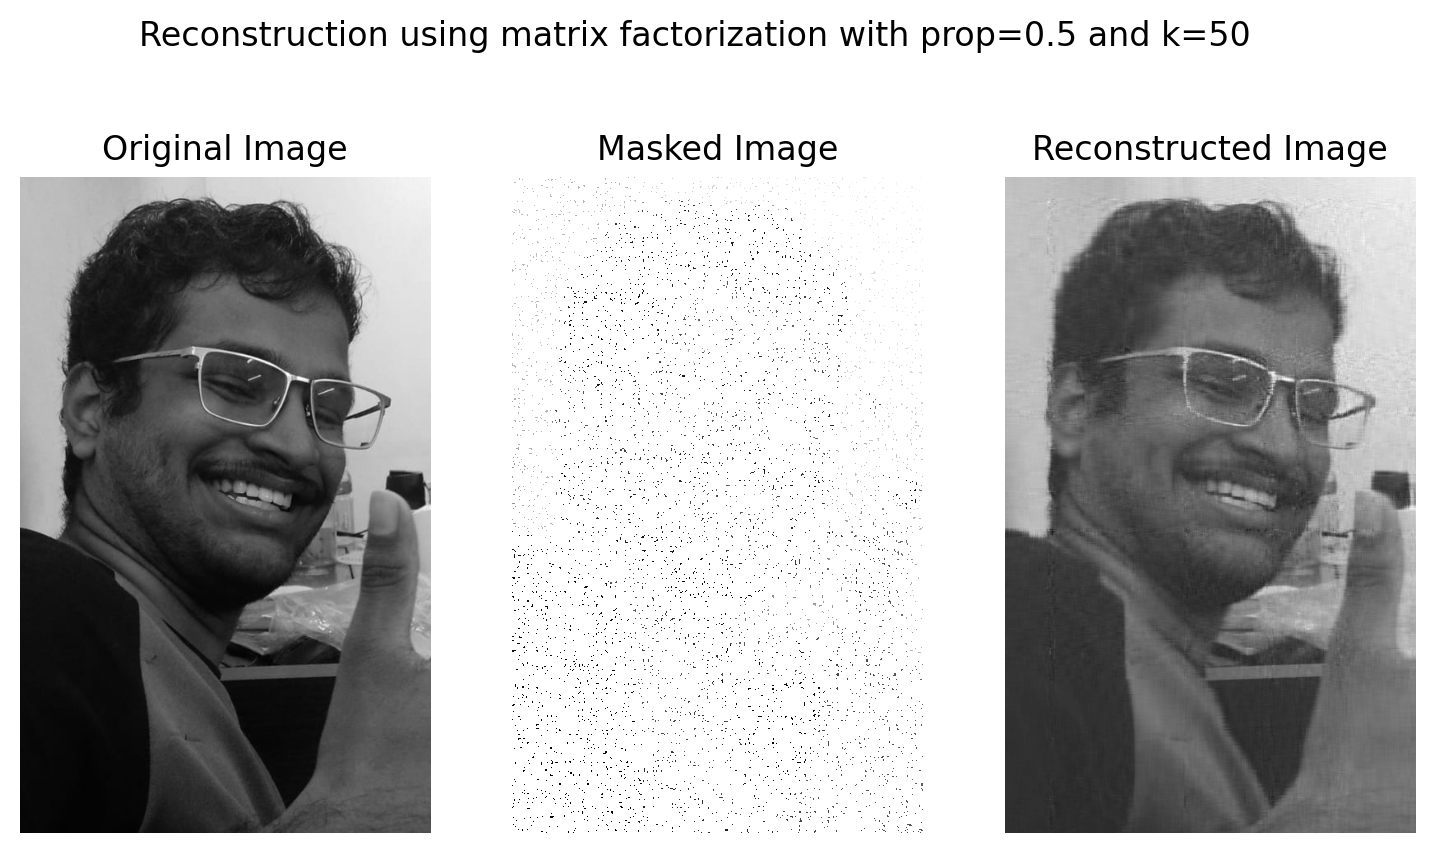

In [132]:
plt.figure(figsize=(9, 5))
plt.suptitle("Reconstruction using matrix factorization with prop=0.5 and k=50")
plt.subplot(1, 3, 1)
plt.title("Original Image")
display_image(greyscale)
plt.subplot(1, 3, 2)
plt.title("Masked Image")
display_image(masked_greyscale_img)
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
display_image(torch.mm(W, H).cpu().detach().numpy())

In [134]:
def calculate_metrics(given_img, prop=0.1, factors=50, colour=False):
	masked_img, mask = mask_image(given_img, prop, colour=colour)
	W, H, loss = factorize(masked_img, factors, device=device)
	reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
	rmse = calculate_rmse(given_img.numpy(), reconstructed_img)
	psnr = calculate_psnr(given_img.numpy(), reconstructed_img)
	return rmse, psnr

rmse, psnr = calculate_metrics(greyscale, 0.3, 50)

print("RMSE for the reconstructed image:", rmse)
print("PSNR for the reconstructed image:", psnr)

RMSE for the reconstructed image: 6.615956145492794
PSNR for the reconstructed image: 31.71895125286067


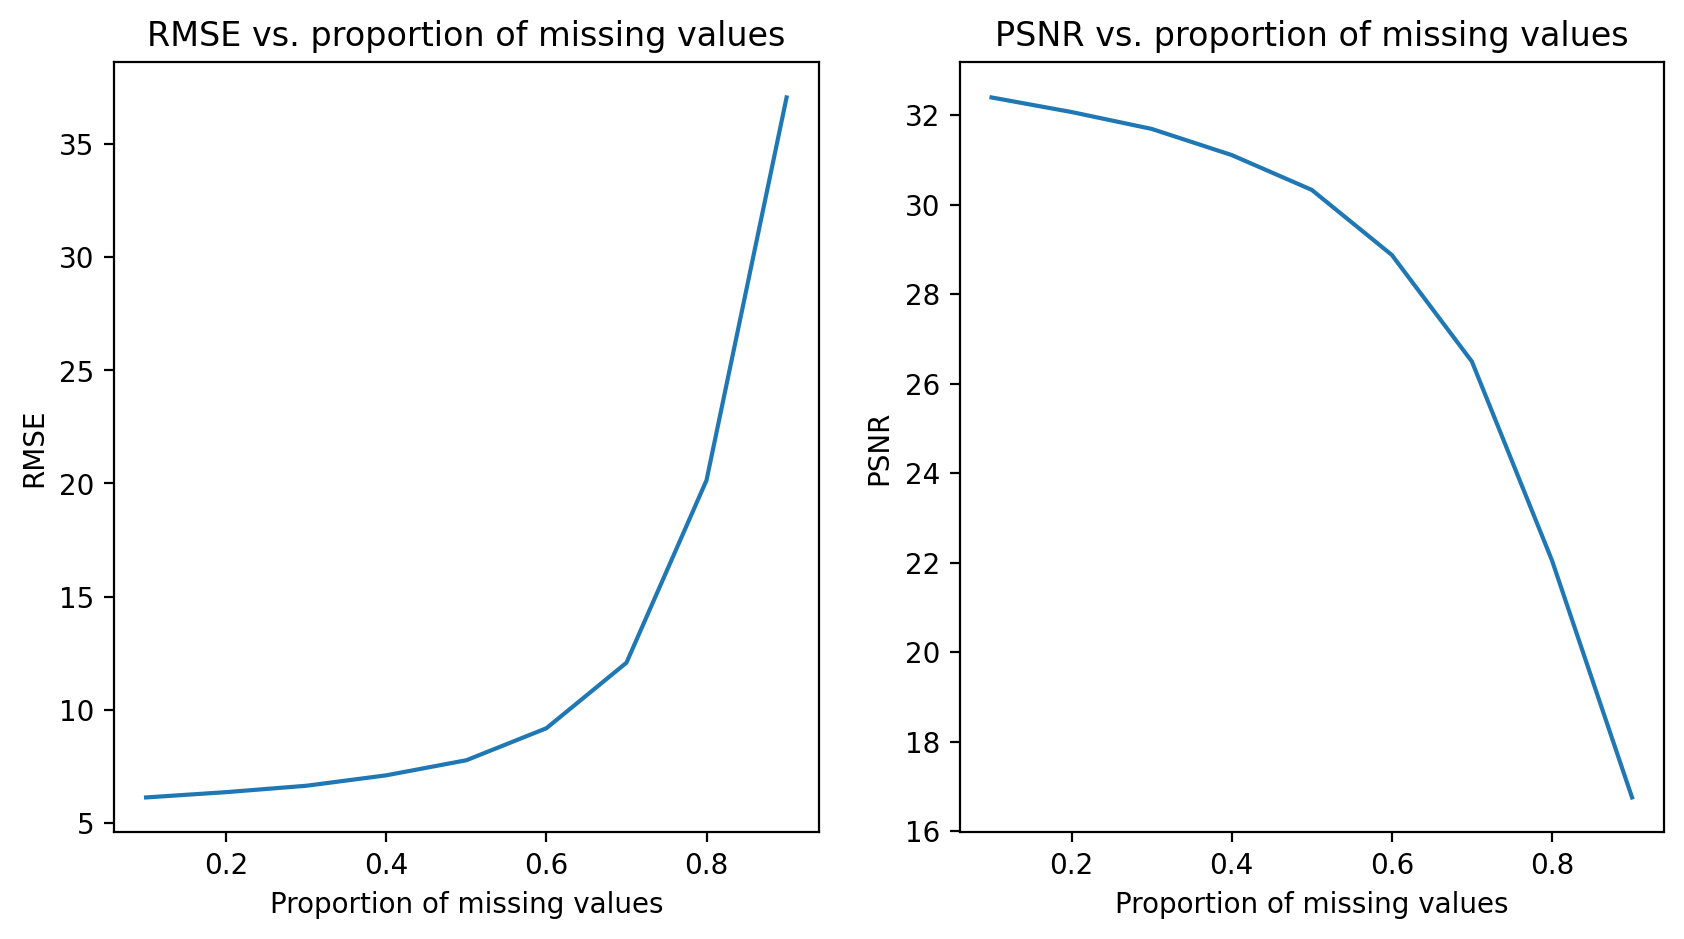

In [135]:
def plot_metric_vs_prop(img, factors=50):
	props = np.linspace(0.1, 0.9, 9)
	rmses = []
	psnrs = []
	for prop in props:
		rmse, psnr = calculate_metrics(img, prop, factors)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(props, rmses)
	ax[0].set_title("RMSE vs. proportion of missing values")
	ax[0].set_xlabel("Proportion of missing values")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(props, psnrs)
	ax[1].set_title("PSNR vs. proportion of missing values")
	ax[1].set_xlabel("Proportion of missing values")
	ax[1].set_ylabel("PSNR")
 
plot_metric_vs_prop(greyscale, 50)

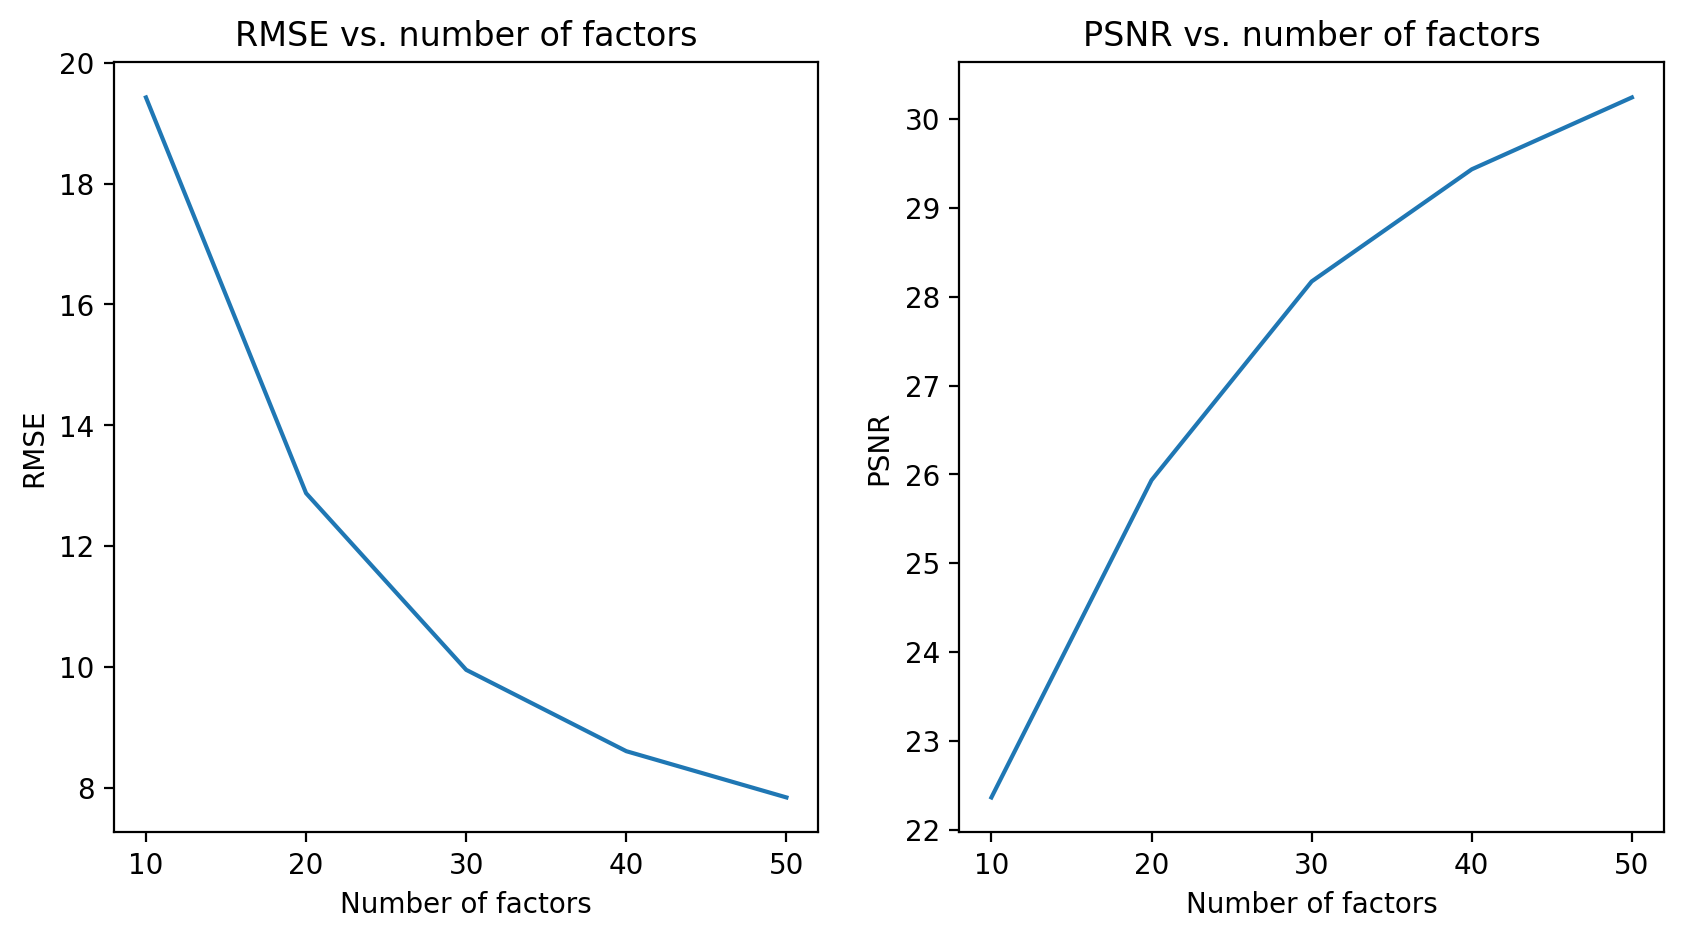

In [136]:
def plot_metric_vs_factors(img, prop=0.3):
	factors = np.arange(10, 51, 10)
	rmses = []
	psnrs = []
	for factor in factors:
		rmse, psnr = calculate_metrics(img, prop, factor)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(factors, rmses)
	ax[0].set_title("RMSE vs. number of factors")
	ax[0].set_xlabel("Number of factors")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(factors, psnrs)
	ax[1].set_title("PSNR vs. number of factors")
	ax[1].set_xlabel("Number of factors")
	ax[1].set_ylabel("PSNR")
 
plot_metric_vs_factors(greyscale, 0.5)

### For Coloured Images

In [145]:
def factorize_coloured_img(img, prop, k):
    masked_img, mask = mask_image(img, prop, colour=True)
    W_R, H_R, loss_R = factorize(masked_img[0, :, :], k, device=device)
    W_G, H_G, loss_G = factorize(masked_img[1, :, :], k, device=device)
    W_B, H_B, loss_B = factorize(masked_img[2, :, :], k, device=device)
    reconstructed_img = torch.stack([torch.mm(W_R, H_R), torch.mm(W_G, H_G), torch.mm(W_B, H_B)])
    reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
    return reconstructed_img, masked_img, loss_R, loss_G, loss_B

reconstructed_img, masked_img, loss_R, loss_G, loss_B = factorize_coloured_img(img, 0.5, 50)
print("Loss for the red channel:", loss_R)
print("Loss for the green channel:", loss_G)
print("Loss for the blue channel:", loss_B)

Loss for the red channel: tensor(2551.1610, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Loss for the green channel: tensor(2421.0224, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Loss for the blue channel: tensor(2457.8197, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)


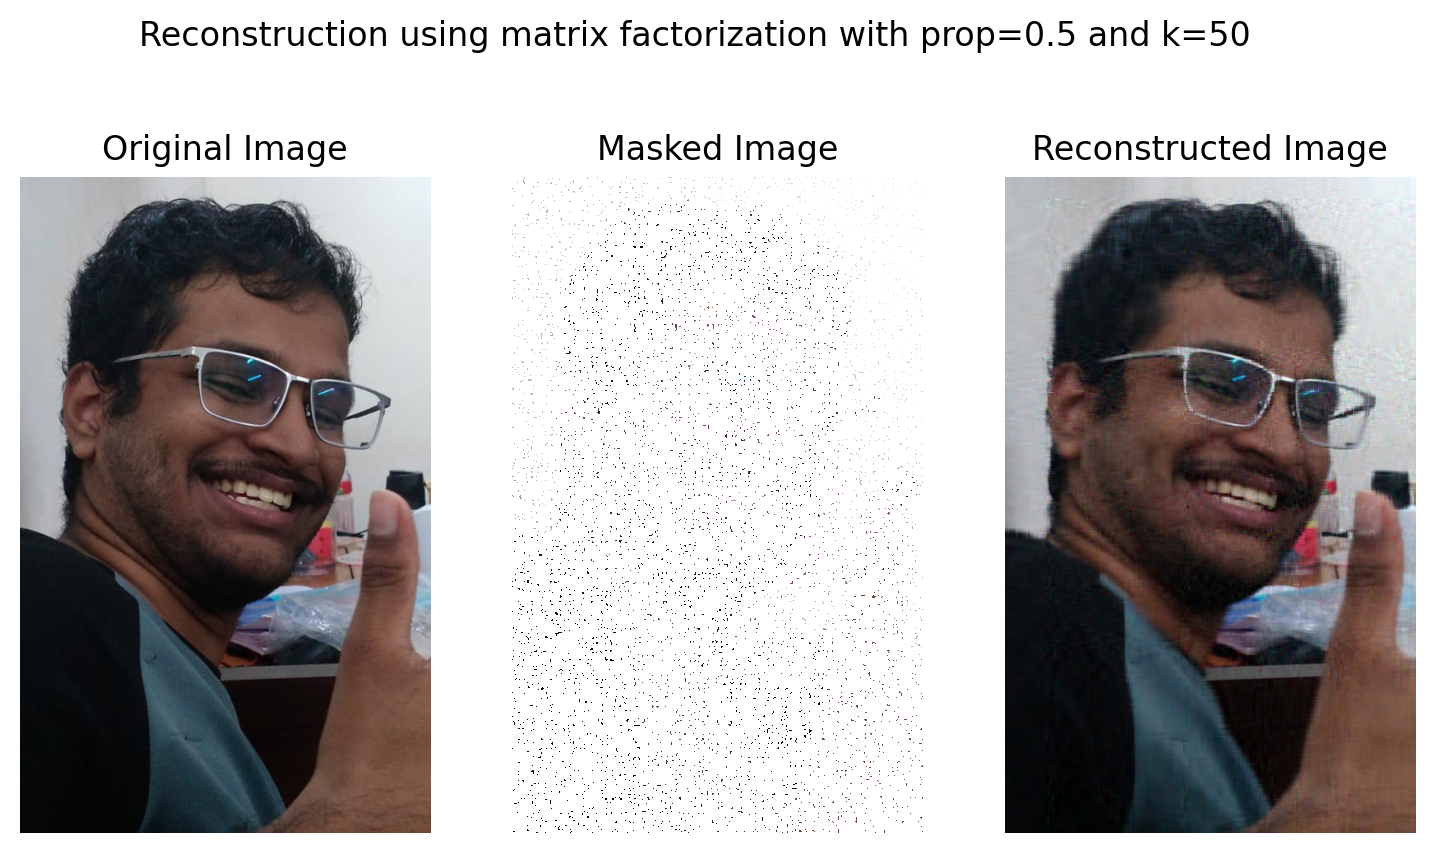

In [146]:
plt.figure(figsize=(9, 5))
plt.suptitle("Reconstruction using matrix factorization with prop=0.5 and k=50")
plt.subplot(1, 3, 1)
plt.title("Original Image")
display_image(img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 2)
plt.title("Masked Image")
display_image(masked_img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
display_image(reconstructed_img.permute(1, 2, 0).cpu().detach().numpy() / 255, gray=False)

In [147]:
def calculate_metrics_for_coloured_img(img, prop=0.1, factors=50):
	reconstructed_img, _, _, _, _ = factorize_coloured_img(img, prop, factors)
	rmse = calculate_rmse(img.numpy(), reconstructed_img.cpu().detach().numpy())
	psnr = calculate_psnr(img.numpy(), reconstructed_img.cpu().detach().numpy())
	return rmse, psnr

rmse, psnr = calculate_metrics_for_coloured_img(img, 0.3, 50)
print("RMSE for the reconstructed image:", rmse)
print("PSNR for the reconstructed image:", psnr)

RMSE for the reconstructed image: 6.651352908224004
PSNR for the reconstructed image: 31.67260378286896


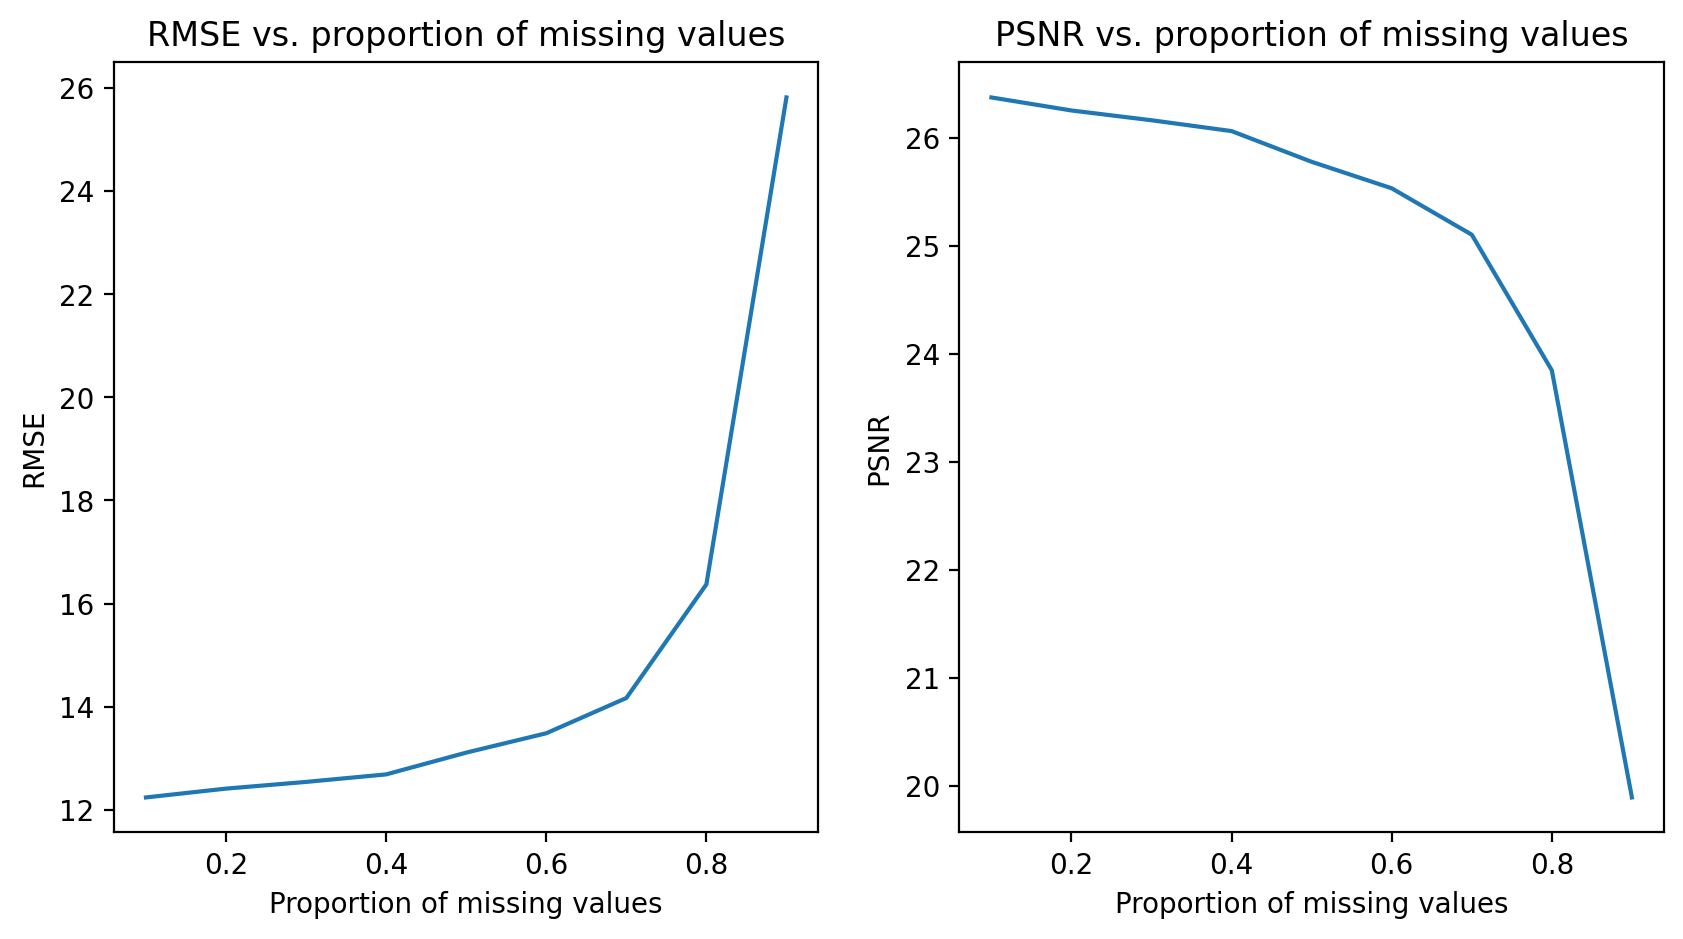

In [148]:
def plot_metric_vs_prop_coloured_img(img, factors=50):
	props = np.linspace(0.1, 0.9, 9)
	rmses = []
	psnrs = []
	for prop in props:
		rmse, psnr = calculate_metrics_for_coloured_img(img, prop, factors)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(props, rmses)
	ax[0].set_title("RMSE vs. proportion of missing values")
	ax[0].set_xlabel("Proportion of missing values")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(props, psnrs)
	ax[1].set_title("PSNR vs. proportion of missing values")
	ax[1].set_xlabel("Proportion of missing values")
	ax[1].set_ylabel("PSNR")

plot_metric_vs_prop_coloured_img(img, 20)

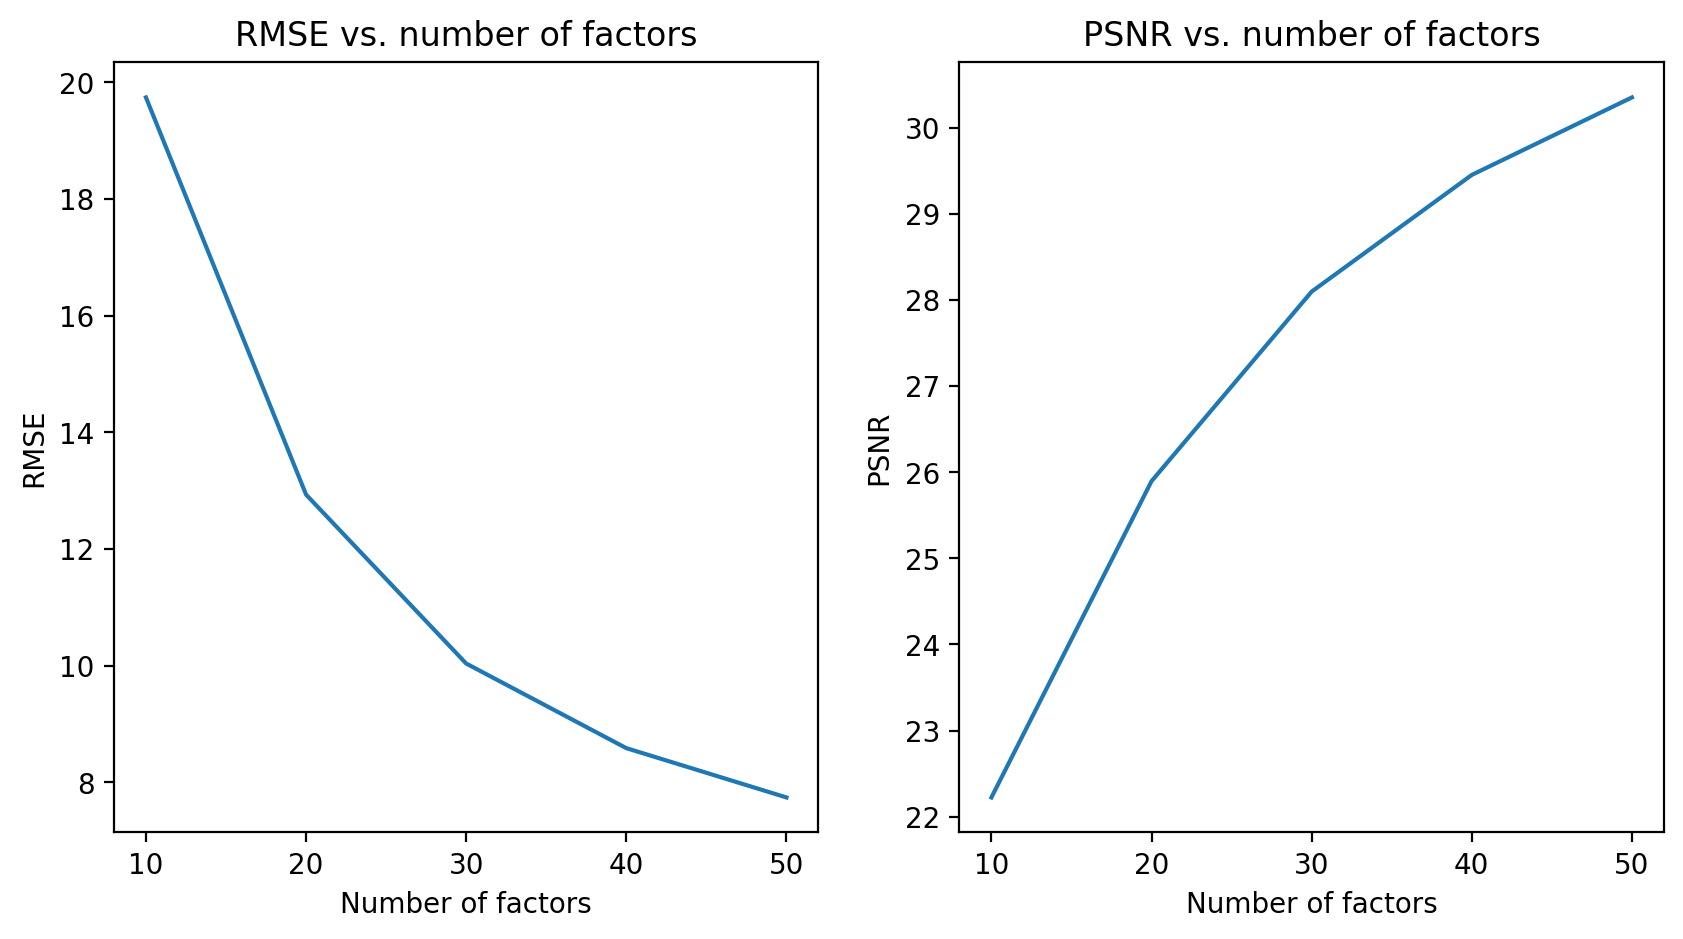

In [149]:
def plot_metric_vs_factors_coloured_img(img, prop=0.3):
	factors = np.arange(10, 51, 10)
	rmses = []
	psnrs = []
	for factor in factors:
		rmse, psnr = calculate_metrics_for_coloured_img(img, prop, factor)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(factors, rmses)
	ax[0].set_title("RMSE vs. number of factors")
	ax[0].set_xlabel("Number of factors")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(factors, psnrs)
	ax[1].set_title("PSNR vs. number of factors")
	ax[1].set_xlabel("Number of factors")
	ax[1].set_ylabel("PSNR")
 
plot_metric_vs_factors_coloured_img(img, 0.5)